# Dynamic WSCC 9-bus System with Switch Event

**Authors**:
 - Markus Mirz <mmirz@eonerc.rwth-aachen.de>
 - Steffen Vogel <stvogel@eoner.rwth-aachen.de>

This Jupyter Notebook shows a simple dynamic phasor simulation of the WSCC-9bus benchmark model.
The grid data is loaded from CIM-XML files, while simulation results are stored in CSV files and plotted via Matplotlib

In [1]:
%gui asyncio
#%matplotlib widget

import dpsim
from dpsim.Event import Event
import glob
import asyncio
import matplotlib.pyplot as plt

### Loading Grid Topology from CIM-XML Model

In [2]:
name = 'WSCC-9bus_dyn_switch'
files = glob.glob('../../CIM/WSCC-09_RX_Dyn/*.xml')
print(files)
system = dpsim.load_cim(name, files, frequency=60)

['../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_DI.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_EQ.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_SV.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_TP.xml']


### Rending Network Topology via Graphiz/SVG

We use Graphviz to render the network model into a layouted SVG figure

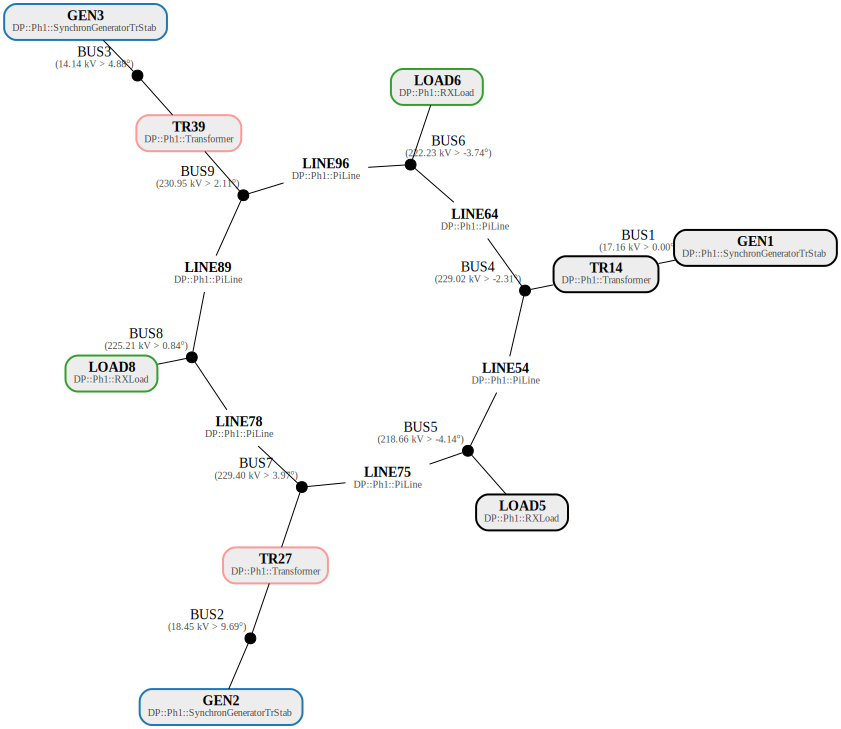

In [3]:
system

### Extending Network with Switch and Load

Here we add a new switch to Bus 9 that is triggered at 0.05s. This component could be added permantely to the CIM model as well using tools like Pintura.

In [4]:
## Switch
sw = dpsim.dp.ph1.Switch("Switch")

sw.R_open = 1e9
sw.R_closed = 0.1
sw.is_closed = False

## Load
load = dpsim.dp.ph1.PQLoadCS("Switched Load")

load.V_nom = 230950
load.P = 30000000
load.Q = 0

## Short
res = dpsim.dp.ph1.Resistor("Short")
res.R = 0.1

## Topology
bus9 = system.nodes["BUS6"]
#bus10 = dpsim.dp.Node("BUS10")
gnd = dpsim.dp.Node.GND()

#system.add_node(bus10)

#system.add_component(res)
#res.connect([bus10, gnd])

#system.add_component(load)
#load.connect([ bus10 ])

system.add_component(sw)
sw.connect([ bus9, gnd ])

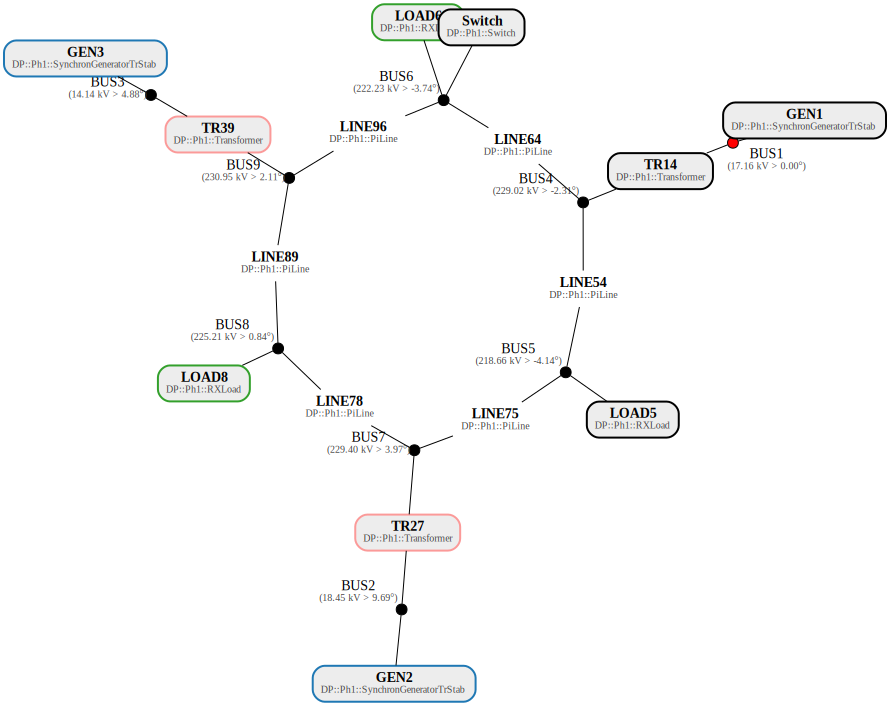

In [5]:
system

### Running Simulation

The actual simulation is done by the C++ DPsim solver. Python is just used for configuration, scripting and analysis

In [7]:
sim = dpsim.Simulation(name, system, timestep=0.0001, duration=2, init_steady_state=True, pbar=True)

#system.components['GEN3'].inertia *= 2
sw.is_closed = False
sim.add_event(0.2, sw, 'is_closed', True)

logger = dpsim.Logger(name)
sim.add_logger(logger)
for i in range(1,4):
	logger.log_attribute(system.components['GEN%d' % i], 'w_r')

for node in system.nodes:
	logger.log_attribute(system.nodes[node], 'v')

sim.start()

HTML(value='Simulation start is pending...')

FloatProgress(value=0.0, max=2.0)

## Analysis

### Read log files and list all column names

In [6]:
import matplotlib.pyplot as plt
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import numpy as np

res = rt.read_timeseries_dpsim('Logs/WSCC-9bus_dyn_switch.csv')

column number: 12
results length: 20001
real column names: ['GEN1.w_r', 'GEN2.w_r', 'GEN3.w_r']
complex column names: ['BUS1.v', 'BUS2.v', 'BUS3.v', 'BUS4.v', 'BUS5.v', 'BUS6.v', 'BUS7.v', 'BUS8.v', 'BUS9.v']


### Phasors at first time step

In [3]:
phasors = ts.phasors(res)
for node, phasor in phasors.items():
    if 'v' in node:
        print(node + ': ' + str(phasor['abs'].values[0]) + '<' + str(phasor['phase'].values[0]))

BUS1.v: 17159.474013800347<-0.014700534417626102
BUS2.v: 18448.552726845748<9.668743412884451
BUS3.v: 14143.998836793044<4.857471341708418
BUS4.v: 229023.7457343671<-2.326826323350636
BUS5.v: 218644.37775942523<-4.162510248086312
BUS6.v: 222216.69713182843<-3.761452031600367
BUS7.v: 229396.2693892911<3.9473081622683006
BUS8.v: 225188.60501802881<0.8091655717701466
BUS9.v: 230944.17338228342<2.081342541770177


### Phasors at last time step

In [4]:
for node, phasor in phasors.items():
    if 'v' in node:
        print(node + ': ' + str(phasor['abs'].values[-1]) + '<' + str(phasor['phase'].values[-1]))

BUS1.v: 13025.599405977595<2.240576333178159
BUS2.v: 15123.371693697136<15.292900188833327
BUS3.v: 9422.635078163432<8.831146775286108
BUS4.v: 116767.50237487533<-1.337260413574393
BUS5.v: 126196.32367511706<-0.5270321533282032
BUS6.v: 358.82178902818686<-76.89397426539477
BUS7.v: 163673.2275253594<9.184893412306502
BUS8.v: 144918.64259687078<5.5966097903758945
BUS9.v: 126244.30009741173<5.718956224576608


### Phasors at last time step in per unit

BUS1.v: 1.039968122048506<-0.014700534417626102
BUS2.v: 1.024919595935875<9.668743412884451
BUS3.v: 1.024927451941525<4.857471341708418
BUS4.v: 0.9957554162363788<-2.326826323350636
BUS5.v: 0.9506277293888054<-4.162510248086312
BUS6.v: 0.9661595527470801<-3.761452031600367
BUS7.v: 0.9973750843012656<3.9473081622683006
BUS8.v: 0.979080891382734<0.8091655717701466
BUS9.v: 1.0041051016621019<2.081342541770177


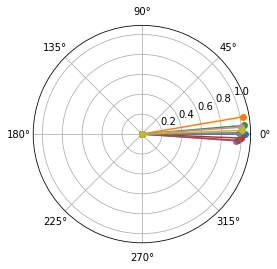

In [7]:
nominal_voltages = {
    'BUS1.v': 16.5e3,
    'BUS2.v': 18e3,
    'BUS3.v': 13.8e3, 
    'BUS4.v': 230e3,
    'BUS5.v': 230e3,
    'BUS6.v': 230e3, 
    'BUS7.v': 230e3,
    'BUS8.v': 230e3,
    'BUS9.v': 230e3
}

plt.figure(1)
for node, nom_voltage in nominal_voltages.items():
    mag = phasors[node]['abs'].values[0] / nom_voltage
    pha = phasors[node]['phase'].values[0]
    print(node + ': ' + str(mag) + '<' + str(pha))
    plt.polar([0, pha / 180 * np.pi], [0, mag], marker='o', label=node)
plt.show()

### Plot node phases

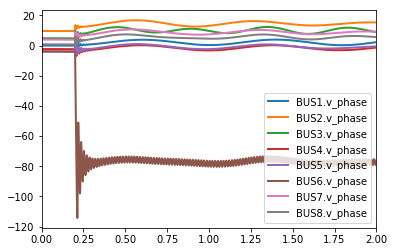

In [9]:
for i in range(1,9):
    pt.plot_timeseries(20, phasors['BUS%d.v' % i]['phase'])

### Plot node voltages

(0.0, 0.06)

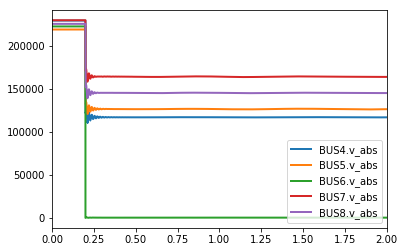

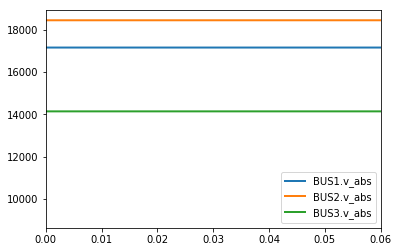

In [12]:
for i in range(4,9):
    pt.plot_timeseries(10, phasors['BUS%d.v' % i]['abs'])
for i in range(1,4):
    pt.plot_timeseries(11, phasors['BUS%d.v' % i]['abs'])
plt.xlim(0.0, 0.06)

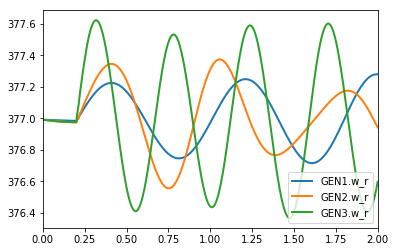

In [15]:
pt.plot_timeseries(1, res['GEN1.w_r'])
pt.plot_timeseries(1, res['GEN2.w_r'])
pt.plot_timeseries(1, res['GEN3.w_r'])